In [1]:
import pandas as pd
from policylearning import *
import matplotlib.pyplot as plt

In [2]:
def plot_grouped_ate(df, cols, treat_var, outcome_var):
    ate = df[df[treat_var] == 1][outcome_var].mean() - df[df[treat_var] == 0][outcome_var].mean()
    cates = []

    for subset in range(1,len(cols)+1):
        bin_df = build_binary_feature_matrix(df, cols[:subset])[0]
        bin_df = bin_df.drop(columns=cols)
        bin_cols = ["bin__" + c for c in cols[:subset]]
        cate_df = compute_cate(bin_df, bin_cols, outcome_var, treat_var)
        cate_df['n'] = cate_df['n_treat'] + cate_df['n_control']
        cates.append((cate_df['n'] * cate_df['ate']).sum() / cate_df['n'].sum())

    plt.plot(cates, label="ATE (grouped)")
    plt.axhline(y=ate, label="ATE", linestyle="--")
    plt.legend()
    plt.xticks(ticks=range(len(cols)), labels=["+"+c for c in cols], rotation=90)

# NSW

## Which features to pick for CATE

In [25]:
df = pd.read_csv("nsw/ec675_nsw.tab", sep="\t")
df = df[df['sample'] == 1]
df.columns

Index(['treated', 'age', 'educ', 'black', 'married', 'nodegree', 'dwincl',
       're74', 're75', 're78', 'hisp', 'early_ra', 'sample'],
      dtype='object')

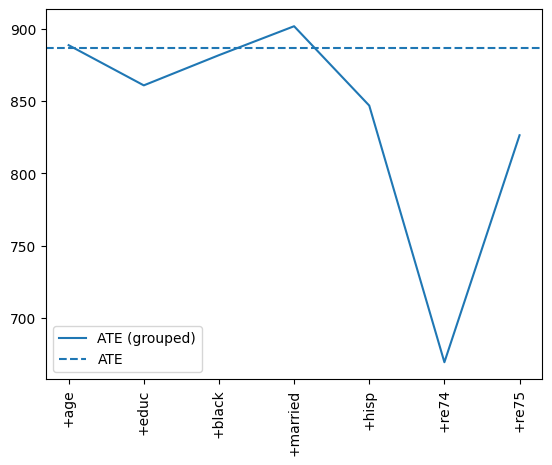

In [26]:
cols = ['age', 'educ', 'black', 'married','hisp',  're74', 're75']
plot_grouped_ate(df, cols, "treated", "re78")

## Finding a good tree

In [ ]:
df = pd.read_csv("nsw/ec675_nsw.tab", sep="\t")
df = df[df['sample'] == 1]
policy_features = ['age', 'educ', 'black', 'married', 'nodegree', 're74', 're75', 'hisp'] # ['age', 'educ', 'black', 'married', 'hisp',  're74', 're75']
cost = 800
class Kwargs:
    def __init__(self, tree_max_depth, tree_min_samples_leaf=None, tree_min_samples_split=None, tree_random_state=None, tree_honest = None, tree_extra_kwargs = None):
        self.tree_max_depth = tree_max_depth 
        self.tree_min_samples_leaf = tree_min_samples_leaf
        self.tree_min_samples_split = tree_min_samples_split
        self.tree_random_state = tree_random_state
        self.tree_honest = tree_honest
        self.tree_extra_kwargs = tree_extra_kwargs

tree_kwargs = resolve_tree_kwargs(Kwargs(tree_max_depth=4))
# df, feature_map, binarization_metadata = build_binary_feature_matrix(df, policy_features)
train_df, test_df = train_test_split(df, train_size=0.5)
tree = get_policy_tree(train_df, policy_features, cost, 're78', 'treated', tree_kwargs, use_forest_nuisance=False)


/orcd/home/002/jhays/lda-1/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/orcd/home/002/jhays/lda-1/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

In [47]:

leaf_cates = get_leaf_cates(
    tree,
    test_df,
    policy_features=policy_features,
    outcome_var="re78",
    treat_var="treated",
)

In [48]:
policy_value_tree(leaf_cates, 0)

796.9060246147957

# Social pressue

In [71]:
df = pd.read_stata("gerber/gerber_generalizability_2/PublicReplicationData.dta")
df = df[df['state'] == 'TX']


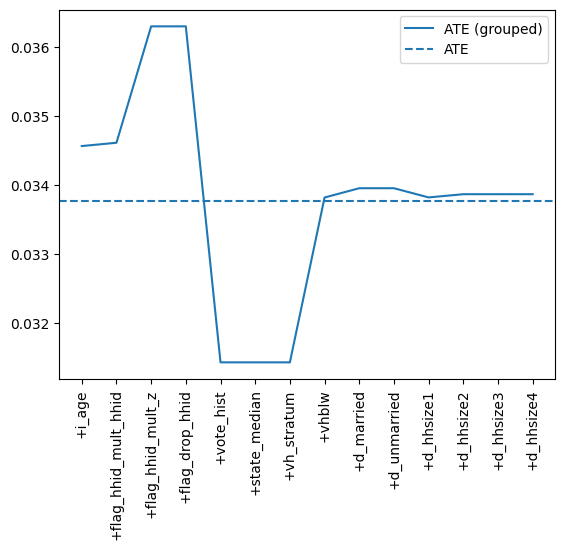

In [72]:
cols = ["voted06", "voted08", "voted09", "voted10", "voted11", "voted12", "voted13", "i_age",
        "age_miss", "age2", "flag_hhid_mult_hhid", "flag_hhid_mult_z", "flag_drop_hhid",
        "vote_hist", "state_median", "vh_stratum", "vhblw", "vhavg", "vhabv", "d_married",
        "d_unmarried", "d_hhsize1", "d_hhsize2", "d_hhsize3", "d_hhsize4"]
cols = ["i_age", "flag_hhid_mult_hhid", "flag_hhid_mult_z", "flag_drop_hhid",
        "vote_hist", "state_median", "vh_stratum", "vhblw", "d_married",
        "d_unmarried", "d_hhsize1", "d_hhsize2", "d_hhsize3", "d_hhsize4"]
plot_grouped_ate(df, cols, 'voted14', 'treat')

## Finding a good tree

In [60]:
df = pd.read_stata("gerber/gerber_generalizability_2/PublicReplicationData.dta")
df = df[df['state'] == 'TX']

In [77]:
policy_features = ["d_married", "d_hhsize1", "d_hhsize2", "d_hhsize3", "d_hhsize4"]
cost = 0.1
class Kwargs:
    def __init__(self, tree_max_depth, tree_min_samples_leaf=None, tree_min_samples_split=None, tree_random_state=None, tree_honest = None, tree_extra_kwargs = None):
        self.tree_max_depth = tree_max_depth 
        self.tree_min_samples_leaf = tree_min_samples_leaf
        self.tree_min_samples_split = tree_min_samples_split
        self.tree_random_state = tree_random_state
        self.tree_honest = tree_honest
        self.tree_extra_kwargs = tree_extra_kwargs

tree_kwargs = resolve_tree_kwargs(Kwargs(tree_max_depth=3))
# df, feature_map, binarization_metadata = build_binary_feature_matrix(df, policy_features)
train_df, test_df = train_test_split(df, train_size=0.5)
tree = get_policy_tree(train_df, policy_features, cost, 'voted14', 'treat', tree_kwargs, use_forest_nuisance=False)

In [78]:
leaf_cates = get_leaf_cates(
    tree,
    test_df,
    policy_features=policy_features,
    outcome_var="voted14",
    treat_var="treat",
)
policy_value_tree(leaf_cates, 0)

0.13583191292314747